In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# datasets

def get_random_sequence(length=10, n_classes=10):
    sequence = torch.randint(low=0, high=n_classes, size=(length,)).squeeze(0).long()
    # compute max for each subsequence - better training
    max_for_subsequence = torch.tensor([torch.max(sequence[:i+1]).item() for i in range(len(sequence))])
    return (sequence, max_for_subsequence)


In [3]:
get_random_sequence(length=16, n_classes=50)

(tensor([35, 13, 31, 37,  7, 17, 10,  7, 45, 17, 34, 12, 47, 32, 24, 45]),
 tensor([35, 35, 35, 37, 37, 37, 37, 37, 45, 45, 45, 45, 47, 47, 47, 47]))

In [ ]:
# model definitions

class AdaptiveSoftmax(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.poly_fit = nn.Parameter(torch.randn(5), requires_grad=True)

    def _get_polynomial_value(self, x: float, c: list[float]) -> float:
        cur_val = 0
        for i in range(len(c) - 1):
            cur_val = (cur_val + c[i]) * x
        return cur_val + c[-1]

    def forward(self, logits):
        """
        from "Softmax is not Enough" Figure 4, adapted to PyTorch
        """
        original_probs = torch.softmax(logits, dim=self.dim)
        entropy = torch.sum(-original_probs * torch.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
        beta = torch.where(
            entropy > 0.5,  # don’t overcorrect low-entropy heads
            torch.maximum(self._get_polynomial_value(entropy, self.poly_fit), torch.tensor(1.0)),  # never increase entropy
            torch.tensor(1.0)
        )
        return torch.softmax(logits * beta, dim=self.dim)
    
    
class MyAttention(nn.Module):
    def __init__(self, d_model, d_internal, adaptive_softmax: bool = True):
        """
        :param d_model: The dimension of the inputs and outputs of the layer (note that the inputs and outputs
        have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation. Your keys and queries
        should both be of this length.
        """
        super().__init__()
        self.d_model = d_model
        self.d_internal = d_internal
        self.sqrt_d = torch.sqrt(torch.tensor(d_internal, dtype=torch.float32))

        self.w_q = nn.Linear(d_model, d_internal, bias=False)
        self.w_k = nn.Linear(d_model, d_internal, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

        self.softmax = AdaptiveSoftmax(dim=-1)
        self.adaptive_softmax = adaptive_softmax

    def forward(self, input_vecs: torch.Tensor):
        q, k, v = self.w_q(input_vecs), self.w_k(input_vecs), self.w_v(input_vecs)
    
        s = q @ k.transpose(-2, -1)

        a = (s / self.sqrt_d)
        
        # mask future tokens
        seq_len = input_vecs.shape[1]
        mask = torch.tril(torch.ones((seq_len, seq_len), device=input_vecs.device))
        a = a * mask.unsqueeze(0)  # batch size is first dimension, tokens
        
        a = self.softmax(a) if self.adaptive_softmax else torch.softmax(a, dim=-1)
        
            
        z = a @ v

        attention_is_all_you_need = z + input_vecs

        return attention_is_all_you_need, a

class MaxNN(torch.nn.Module):
    def __init__(self, n_classes=10, n_feats=128, activation=torch.nn.GELU(), adaptive_softmax: bool = False):
        super().__init__()
        self.n_classes = n_classes
        self.n_feats = n_feats
        self.activation = activation
        
        self.embedding = nn.Embedding(n_classes, n_feats)

        self.attention = MyAttention(d_model=n_feats, d_internal=n_feats//2, adaptive_softmax=adaptive_softmax)

        self.final_dense1 = nn.Linear(n_feats, n_feats)
        self.final_dense2 = nn.Linear(n_feats, n_classes)
        
        self.attention_patterns = []
        
    
    def forward(self, x, capture_attention=False):

        # Process x through dense layers
        x = self.embedding(x)
            
        # print(f"{x.shape=}")
        attn_output, attention_pattern = self.attention(x)
        # print(f"{attn_output.shape=} {attention_pattern.shape=}")
        if capture_attention:
            self.attention_patterns.append(attention_pattern.detach().cpu())
        
        x = attn_output
        
        # Final dense layers
        x = self.final_dense1(x)
        x = self.activation(x)
        x = self.final_dense2(x)

        return x
    
    def get_attention_pattern(self):
        patterns = torch.cat(self.attention_patterns, dim=0)
        # self.attention_patterns = []
        return patterns
      

  
  
# POLY_FIT = torch.tensor([-0.037, 0.481, -2.3, 4.917, -1.791]) # Figure 6

# def softmax_adaptive_temperature(logits, dim, poly_fit=POLY_FIT, dtype=torch.float32):
#     """
#     from "Softmax is not Enough" Figure 4, adapted to PyTorch
#     """
#     original_probs = torch.softmax(logits, dim=dim, dtype=dtype)
#     entropy = torch.sum(-original_probs * torch.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
#     beta = torch.where(
#         entropy > 0.5,  # don’t overcorrect low-entropy heads
#         torch.maximum(get_polynomial_value(entropy, poly_fit), torch.tensor(1.0)),  # never increase entropy
#         torch.tensor(1.0)
#     )
#     return torch.softmax(logits * beta, dim=dim, dtype=dtype)

In [ ]:
# training and evaluation functions

def train_model(model, train_dataloader):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10): # 100_000 steps total
        for i, (x, y) in enumerate(train_dataloader):
            logits = model(x)
            l = loss(logits.reshape(-1, logits.shape[-1]), y.reshape(-1))
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

        # this is loss on last iteration of an epoch - not a good indicator, but a decent heuristic
        print(f"Epoch {epoch} Loss: {l.item()}")
        
def test_model(model, test_dataloader):
    loss = nn.CrossEntropyLoss()
    
    test_loss = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            logits = model(x, capture_attention=True)
            l = loss(logits[-1, :], y[-1])
            test_loss.append(l.item())
        attentions = model.get_attention_pattern()
        last_logit_attentions = attentions[:, -1, :].unsqueeze(1)  # get attention patterns for last query position
        
    return sum(test_loss)/len(test_loss), last_logit_attentions

def evaluate_models(length=10, n_classes=10):
    train_dataloader = torch.utils.data.DataLoader(
        [get_random_sequence(length, n_classes) for _ in range(20_000)], batch_size=20, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        [get_random_sequence(length, n_classes) for _ in range(32)], batch_size=1, shuffle=False
    )
    test_dataloader_2 = torch.utils.data.DataLoader(
        [get_random_sequence(length*2, n_classes) for _ in range(32)], batch_size=1, shuffle=False
    )

    model_softmax = MaxNN(n_classes=n_classes, n_feats=128)
    model_adaptive_softmax = MaxNN(n_classes=n_classes, n_feats=128, adaptive_softmax=True)

    print(f"Evaluating models with sequence length {length}")
    
    print("original")
    train_model(model_softmax, train_dataloader)
    test_original, average_attention_original, last_attention_original = test_model(model_softmax, test_dataloader)
    print(f"Test loss on length {length} = {test_original}")
    test_original_2, average_attention_original_2, last_attention_original_2 = test_model(model_softmax, test_dataloader_2)
    print(f"Test loss on length {length*2} = {test_original_2}")
    
    print("adaptive")
    train_model(model_adaptive_softmax, train_dataloader)
    test_adaptive, average_attention_adaptive, last_attention_adaptive = test_model(model_adaptive_softmax, test_dataloader)
    print(f"Test loss on length {length} = {test_adaptive}")
    test_adaptive_2, average_attention_adaptive_2, last_attention_adaptive_2 = test_model(model_adaptive_softmax, test_dataloader_2)
    print(f"Test loss on length {length*2} = {test_adaptive_2}")

    return {
        "original": test_original,
        "original_2": test_original_2,
        "adaptive": test_adaptive,
        "adaptive_2": test_adaptive_2,
        "average_attention_original": average_attention_original,
        "average_attention_original_2": average_attention_original_2,
        "average_attention_adaptive": average_attention_adaptive,
        "average_attention_adaptive_2": average_attention_adaptive_2,
        "last_attention_original": last_attention_original,
        "last_attention_original_2": last_attention_original_2,
        "last_attention_adaptive": last_attention_adaptive,
        "last_attention_adaptive_2": last_attention_adaptive_2
    }

In [6]:
results = {}
sequence_lengths = [16, 32, 64, 128, 256]

for length in sequence_lengths:  # Start with first 5, can run more later
    results[length] = evaluate_models(length=length, n_classes=50)
    

Evaluating models with sequence length 16
original
Epoch 0 Loss: 0.09169737994670868
Epoch 1 Loss: 0.0795554369688034
Epoch 2 Loss: 0.03811971843242645
Epoch 3 Loss: 0.1294192671775818
Epoch 4 Loss: 0.062230855226516724
Epoch 5 Loss: 0.15107373893260956
Epoch 6 Loss: 0.09797843545675278
Epoch 7 Loss: 0.0518253818154335
Epoch 8 Loss: 0.2039007842540741
Epoch 9 Loss: 0.04796624183654785
Test loss on length 16 = 0.07034173143747761
Test loss on length 32 = 0.04457498918011743
adaptive
Epoch 0 Loss: 0.29554611444473267
Epoch 1 Loss: 0.43604007363319397
Epoch 2 Loss: 0.2397596389055252
Epoch 3 Loss: 0.1688910871744156
Epoch 4 Loss: 0.22767753899097443
Epoch 5 Loss: 0.14268016815185547
Epoch 6 Loss: 0.2937053442001343
Epoch 7 Loss: 0.25624656677246094
Epoch 8 Loss: 0.16847412288188934
Epoch 9 Loss: 0.14499084651470184
Test loss on length 16 = 0.22803991465530368
Test loss on length 32 = 0.1654987764870674
Evaluating models with sequence length 32
original
Epoch 0 Loss: 0.21150605380535126
Ep

In [12]:
# visualization

def visualize_attention_grid(results_dict, title="Attention Pattern Comparison"):
    """
    Creates a grid visualization of attention patterns across different sequence lengths
    and model configurations (similar to the paper's Figure 6).
    """
    # Sort by sequence length
    lengths = sorted(results_dict.keys())
    
    fig, axes = plt.subplots(4, len(lengths), figsize=(3*len(lengths), 12))
    
    for col_idx, length in enumerate(lengths):
        data = results_dict[length]
        
        # Top row: Original softmax
        ax_original = axes[0, col_idx] if len(lengths) > 1 else axes[0]
        im1 = ax_original.imshow(data["average_attention_original"].squeeze(0), cmap='Blues', aspect='auto')
        ax_original.set_title(f"sequence: {length}")
        ax_original.set_ylabel("Query" if col_idx == 0 else "")
        ax_original.set_xlabel("Key")
            
        # Second row: Original softmax for length*2
        ax_original_2 = axes[1, col_idx] if len(lengths) > 1 else axes[1]
        im1_2 = ax_original_2.imshow(data["average_attention_original_2"].squeeze(0), cmap='Blues', aspect='auto')
        ax_original_2.set_title(f"sequence: {length*2}")
        ax_original_2.set_ylabel("Query" if col_idx == 0 else "")
        ax_original_2.set_xlabel("Key")
        
        # Third row: Adaptive softmax
        ax_adaptive = axes[2, col_idx] if len(lengths) > 1 else axes[2]
        im2 = ax_adaptive.imshow(data["average_attention_adaptive"].squeeze(0), cmap='Blues', aspect='auto')
        ax_adaptive.set_title(f"sequence: {length}")
        ax_adaptive.set_ylabel("Query" if col_idx == 0 else "")
        ax_adaptive.set_xlabel("Key")
            
        # Bottom row: Adaptive softmax for length*2
        ax_adaptive_2 = axes[3, col_idx] if len(lengths) > 1 else axes[3]
        im2_2 = ax_adaptive_2.imshow(data["average_attention_adaptive_2"].squeeze(0), cmap='Blues', aspect='auto')
        ax_adaptive_2.set_title(f"sequence: {length*2}")
        ax_adaptive_2.set_ylabel("Query" if col_idx == 0 else "")
        ax_adaptive_2.set_xlabel("Key")
    
    # Add row labels on the left
    fig.text(-0.15, 0.75, 'Original\nSoftmax', rotation=0, verticalalignment='center', 
             fontsize=12, weight='bold')
    fig.text(-0.15, 0.25, 'Adaptive\nSoftmax', rotation=0, verticalalignment='center', 
             fontsize=12, weight='bold')
    
    plt.suptitle(title, fontsize=14, weight='bold', y=0.98)
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])
    plt.show()
    
    # Print test losses for comparison
    print("\nTest Loss Comparison:")
    for length in lengths:
        print(f"Length {length}: Original={results_dict[length]['original']:.4f}, Original 2x={results_dict[length]['original_2']:.4f}, "
              f"Adaptive={results_dict[length]['adaptive']:.4f}, Adaptive 2x={results_dict[length]['adaptive_2']:.4f}")

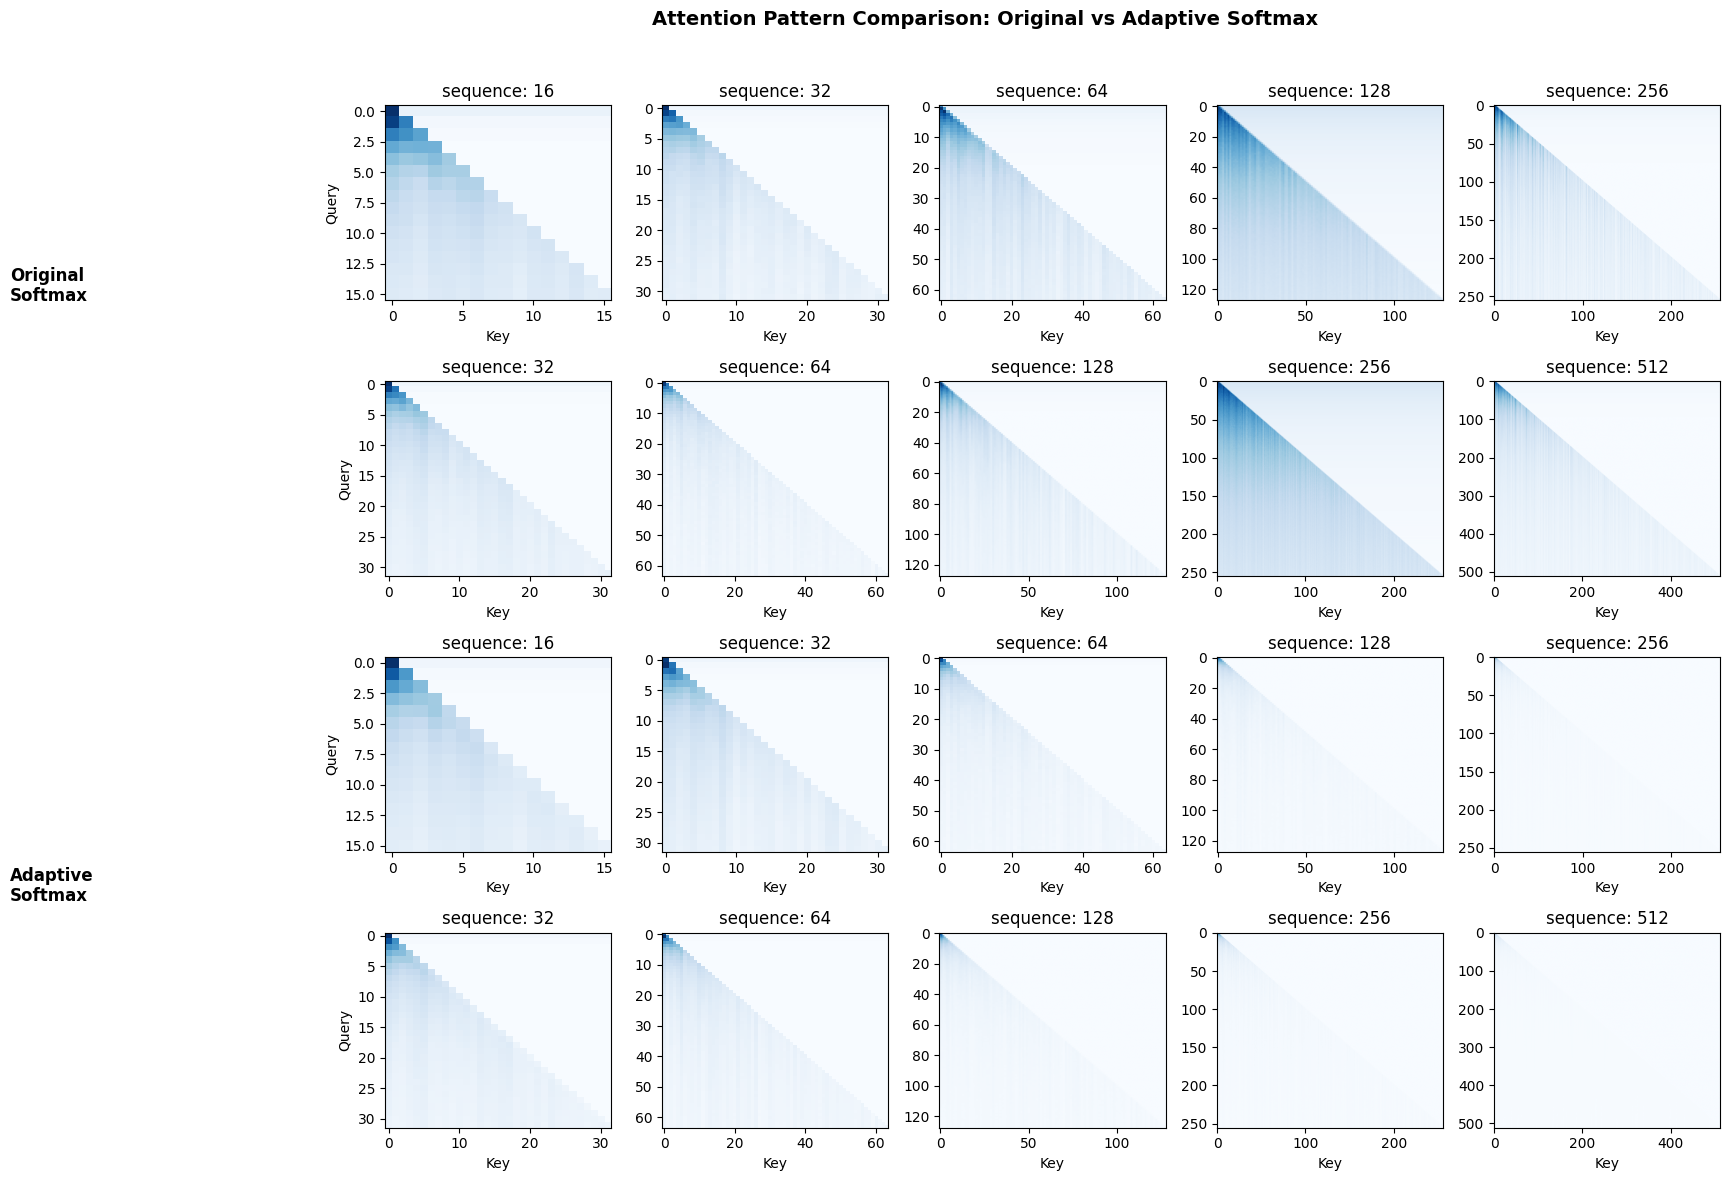


Test Loss Comparison:
Length 16: Original=0.0703, Original 2x=0.0446, Adaptive=0.2280, Adaptive 2x=0.1655
Length 32: Original=0.1804, Original 2x=0.1157, Adaptive=0.0742, Adaptive 2x=0.0406
Length 64: Original=0.2899, Original 2x=0.1450, Adaptive=0.0886, Adaptive 2x=0.0617
Length 128: Original=0.7492, Original 2x=0.6024, Adaptive=0.0700, Adaptive 2x=0.0458
Length 256: Original=0.2106, Original 2x=0.1235, Adaptive=0.0394, Adaptive 2x=0.0259


In [13]:
visualize_attention_grid(results, title="Attention Pattern Comparison: Original vs Adaptive Softmax")

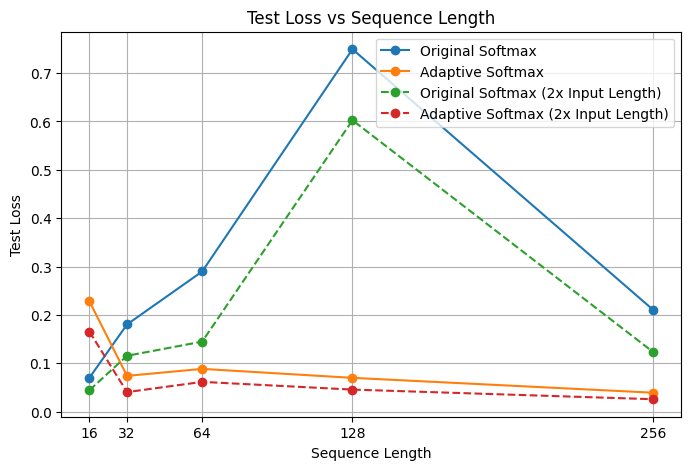

In [11]:
# plot test losses

def plot_test_losses(results_dict):
    lengths = sorted(results_dict.keys())
    original_losses = [results_dict[length]['original'] for length in lengths]
    adaptive_losses = [results_dict[length]['adaptive'] for length in lengths]
    original_losses_2 = [results_dict[length]['original_2'] for length in lengths]
    adaptive_losses_2 = [results_dict[length]['adaptive_2'] for length in lengths]

    plt.figure(figsize=(8, 5))
    plt.plot(lengths, original_losses, marker='o', label='Original Softmax')
    plt.plot(lengths, adaptive_losses, marker='o', label='Adaptive Softmax')
    plt.plot(lengths, original_losses_2, marker='o', label='Original Softmax (2x Input Length)', linestyle='--')
    plt.plot(lengths, adaptive_losses_2, marker='o', label='Adaptive Softmax (2x Input Length)', linestyle='--')
    plt.xlabel('Sequence Length')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Sequence Length')
    plt.xticks(lengths)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_test_losses(results)